RGB Results:
Random Forest:
Training set class counts:
{'apple': 62, 'banana': 63, 'beetroot': 68, 'bell pepper': 78, 'cabbage': 74, 'carrot': 70, 'cauliflower': 65, 'chilli pepper': 78, 'corn': 71, 'cucumber': 78, 'eggplant': 69, 'garlic': 77, 'ginger': 56, 'grapes': 85, 'jalepeno': 75, 'kiwi': 74, 'lemon': 66, 'lettuce': 82, 'mango': 66, 'onion': 77, 'orange': 56, 'paprika': 67, 'pear': 75, 'peas': 82, 'pineapple': 83, 'pomegranate': 66, 'potato': 64, 'raddish': 68, 'soy beans': 83, 'spinach': 80, 'sweetpotato': 61, 'tomato': 81, 'turnip': 82, 'watermelon': 70}
Validation set class counts:
{'apple': 10, 'banana': 9, 'beetroot': 10, 'bell pepper': 9, 'cabbage': 10, 'carrot': 9, 'cauliflower': 10, 'chilli pepper': 9, 'corn': 10, 'cucumber': 10, 'eggplant': 10, 'garlic': 10, 'ginger': 10, 'grapes': 9, 'jalepeno': 9, 'kiwi': 10, 'lemon': 10, 'lettuce': 9, 'mango': 10, 'onion': 10, 'orange': 9, 'paprika': 10, 'pear': 10, 'peas': 10, 'pineapple': 10, 'pomegranate': 10, 'potato': 10, 'raddi

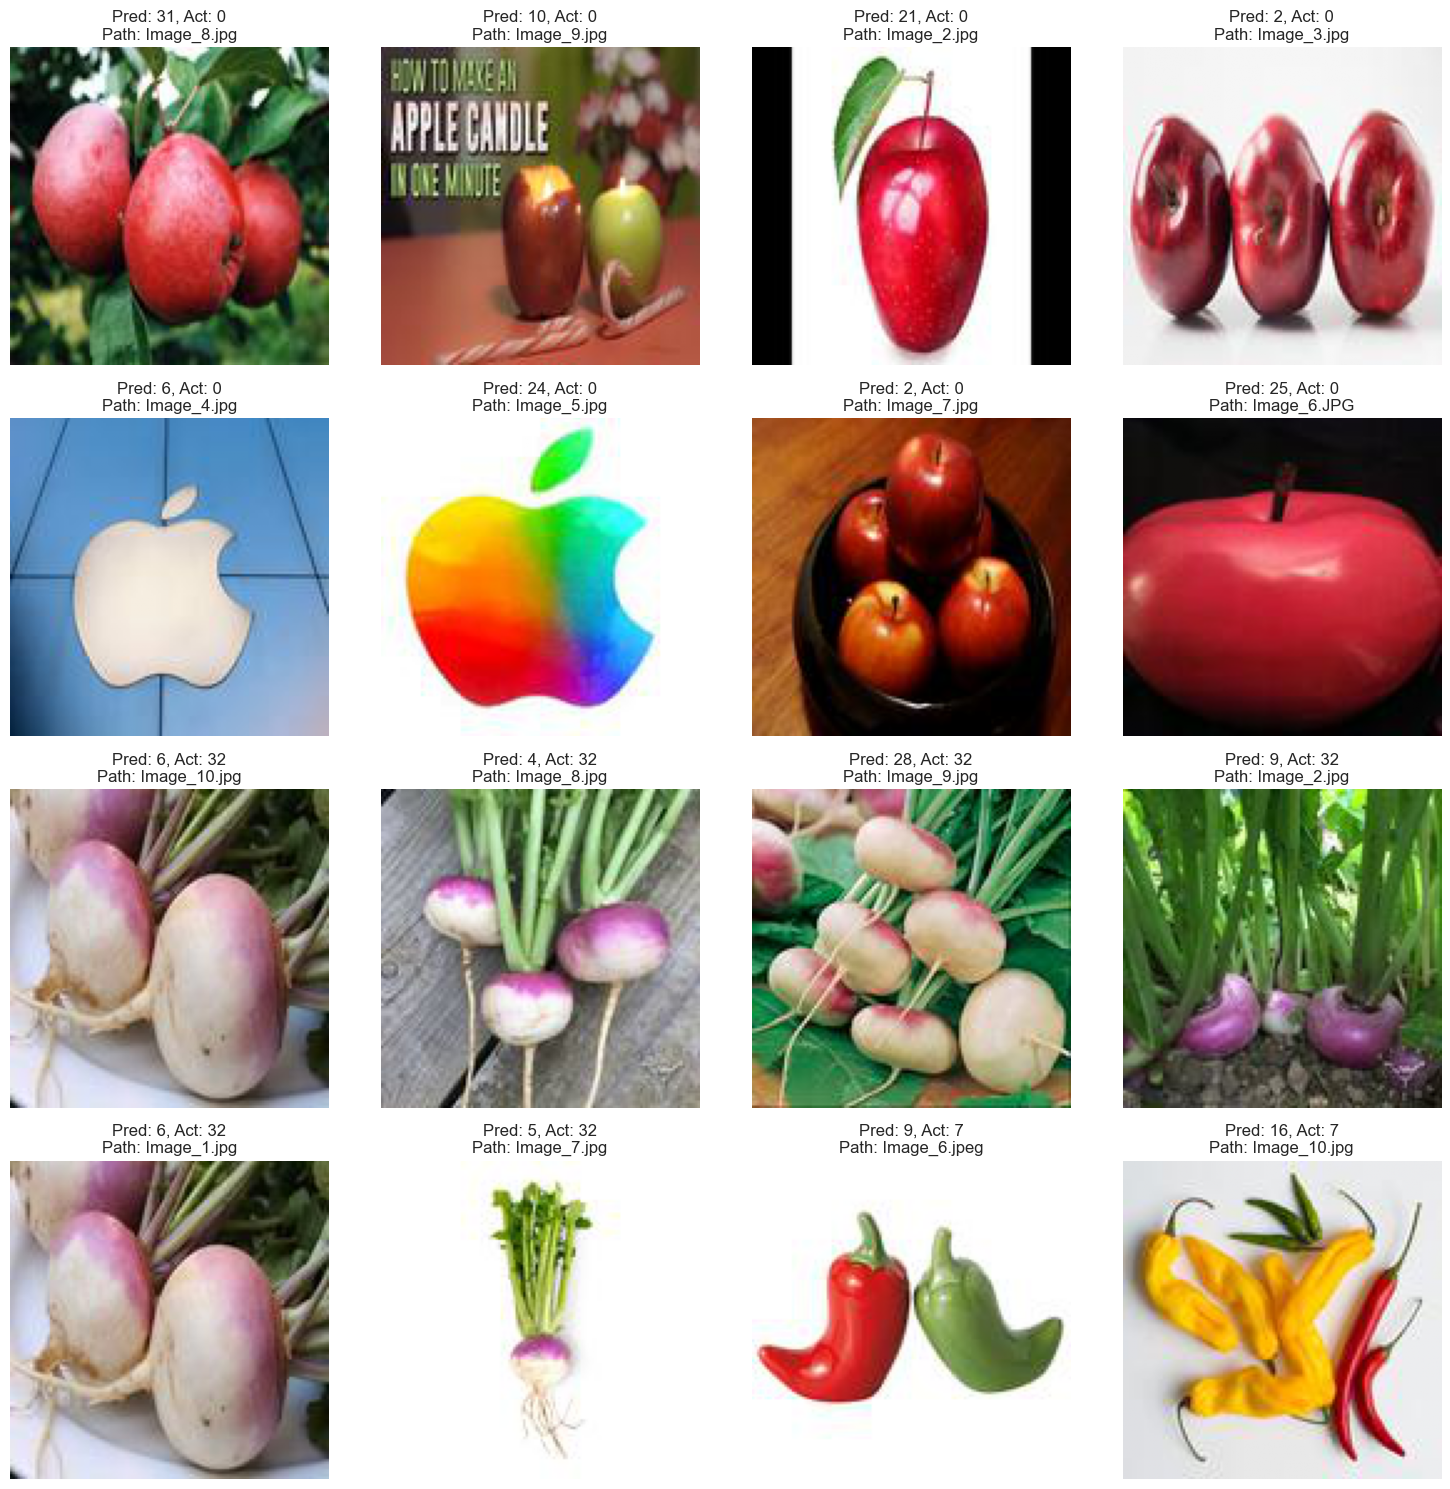

In [5]:
import os
import numpy as np
from PIL import Image
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

DIR_REAL_TRAIN = '/Users/alexchilton/Downloads/working2/train'
DIR_REAL_TEST = '/Users/alexchilton/Downloads/working2/test'
DIR_REAL_VALIDATION = '/Users/alexchilton/Downloads/working2/validation'

exclude_classes = ['capsicum', 'sweetcorn']

def load_images_from_folder(folder, image_size=(128, 128), exclude_classes=None, grayscale=False):
    if exclude_classes is None:
        exclude_classes = []
    images = []
    labels = []
    filenames = []
    for class_name in os.listdir(folder):
        if class_name in exclude_classes:
            continue
        class_folder = os.path.join(folder, class_name)
        if os.path.isdir(class_folder):
            for filename in os.listdir(class_folder):
                img_path = os.path.join(class_folder, filename)
                img = Image.open(img_path)
                if grayscale:
                    img = img.convert('L')  # Convert to grayscale
                    img = img.resize(image_size)  # Resize image to the specified size
                    img_array = np.array(img)
                    img_array = img_array[:, :, np.newaxis]  # Add channel dimension
                else:
                    img = img.resize(image_size)  # Resize image to the specified size
                    img_array = np.array(img)
                    if img_array.shape == (image_size[0], image_size[1], 4):  # Check for RGBA images
                        img_array = img_array[:, :, :3]  # Discard the alpha channel
                    if img_array.shape != (image_size[0], image_size[1], 3):  # Ensure the image is RGB
                        print(f"Skipping image {img_path} due to incorrect shape: {img_array.shape}")
                        continue
                img_array = img_array.flatten()  # Flatten the image
                images.append(img_array)
                labels.append(class_name)
                filenames.append(filename)
    return np.array(images), np.array(labels), filenames

def count_samples_per_class(y, label_encoder):
    unique_classes, counts = np.unique(y, return_counts=True)
    class_counts = {label_encoder.inverse_transform([cls])[0]: count for cls, count in zip(unique_classes, counts)}
    return class_counts

def train_and_evaluate(clf, X_train, y_train, X_val, y_val, X_test, y_test, label_encoder):
    print("Training set class counts:")
    print(count_samples_per_class(y_train, label_encoder))

    print("Validation set class counts:")
    print(count_samples_per_class(y_val, label_encoder))

    print("Test set class counts:")
    print(count_samples_per_class(y_test, label_encoder))

    clf.fit(X_train, y_train)

    y_val_pred = clf.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    print(f'Validation Accuracy: {val_accuracy}')

    y_test_pred = clf.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print(f'Test Accuracy: {test_accuracy}')

    misclassified_indices_val = np.where(y_val != y_val_pred)[0]
    misclassified_indices_test = np.where(y_test != y_test_pred)[0]

    return val_accuracy, test_accuracy, misclassified_indices_val, misclassified_indices_test

# Load datasets in grayscale
X_train_gray, y_train_gray, filenames_train_gray = load_images_from_folder(DIR_REAL_TRAIN, exclude_classes=exclude_classes, grayscale=True)
X_test_gray, y_test_gray, filenames_test_gray = load_images_from_folder(DIR_REAL_TEST, exclude_classes=exclude_classes, grayscale=True)
X_val_gray, y_val_gray, filenames_val_gray = load_images_from_folder(DIR_REAL_VALIDATION, exclude_classes=exclude_classes, grayscale=True)

# Load datasets in RGB
X_train_rgb, y_train_rgb, filenames_train_rgb = load_images_from_folder(DIR_REAL_TRAIN, exclude_classes=exclude_classes, grayscale=False)
X_test_rgb, y_test_rgb, filenames_test_rgb = load_images_from_folder(DIR_REAL_TEST, exclude_classes=exclude_classes, grayscale=False)
X_val_rgb, y_val_rgb, filenames_val_rgb = load_images_from_folder(DIR_REAL_VALIDATION, exclude_classes=exclude_classes, grayscale=False)

# Normalize the image data to [0, 1]
X_train_rgb = X_train_rgb / 255.0
X_test_rgb = X_test_rgb / 255.0
X_val_rgb = X_val_rgb / 255.0

# Ensure the labels are encoded as integers
label_encoder = LabelEncoder()
y_train_rgb_encoded = label_encoder.fit_transform(y_train_rgb)
y_test_rgb_encoded = label_encoder.transform(y_test_rgb)
y_val_rgb_encoded = label_encoder.transform(y_val_rgb)

# Update the print_misclassified_samples function to include filenames
def print_misclassified_samples(X, y_true, y_pred, misclassified_indices, filenames, title, grayscale=False):
    print(f"{title} - Misclassified Samples:")
    for index in misclassified_indices[:16]:  # Limit to the first 16 misclassified samples
        print(f"Index: {index}, Filename: {filenames[index]}, Predicted: {y_pred[index]}, Actual: {y_true[index]}")

    num_images = min(16, len(misclassified_indices))  # Ensure we don't exceed the number of misclassified samples
    num_cols = 4
    num_rows = (num_images + num_cols - 1) // num_cols  # Calculate the number of rows needed

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))
    axes = axes.flatten()

    for ax, index in zip(axes, misclassified_indices[:num_images]):
        if grayscale:
            img = X[index].reshape(128, 128, 1)
            ax.imshow(img, cmap='gray')
        else:
            img = X[index].reshape(128, 128, 3)
            ax.imshow(img)
        ax.set_title(f"Pred: {y_pred[index]}, Act: {y_true[index]}\nPath: {filenames[index]}")
        ax.axis('off')

    # Hide any remaining empty subplots
    for ax in axes[num_images:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Initialize classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train and evaluate classifier on RGB data
print("RGB Results:")
print("Random Forest:")
val_acc, test_acc, misclassified_val, misclassified_test = train_and_evaluate(rf_clf, X_train_rgb, y_train_rgb_encoded, X_val_rgb, y_val_rgb_encoded, X_test_rgb, y_test_rgb_encoded, label_encoder)

print_misclassified_samples(X_test_rgb, y_test_rgb_encoded, rf_clf.predict(X_test_rgb), misclassified_test, filenames_test_rgb, "Random Forest RGB Test")



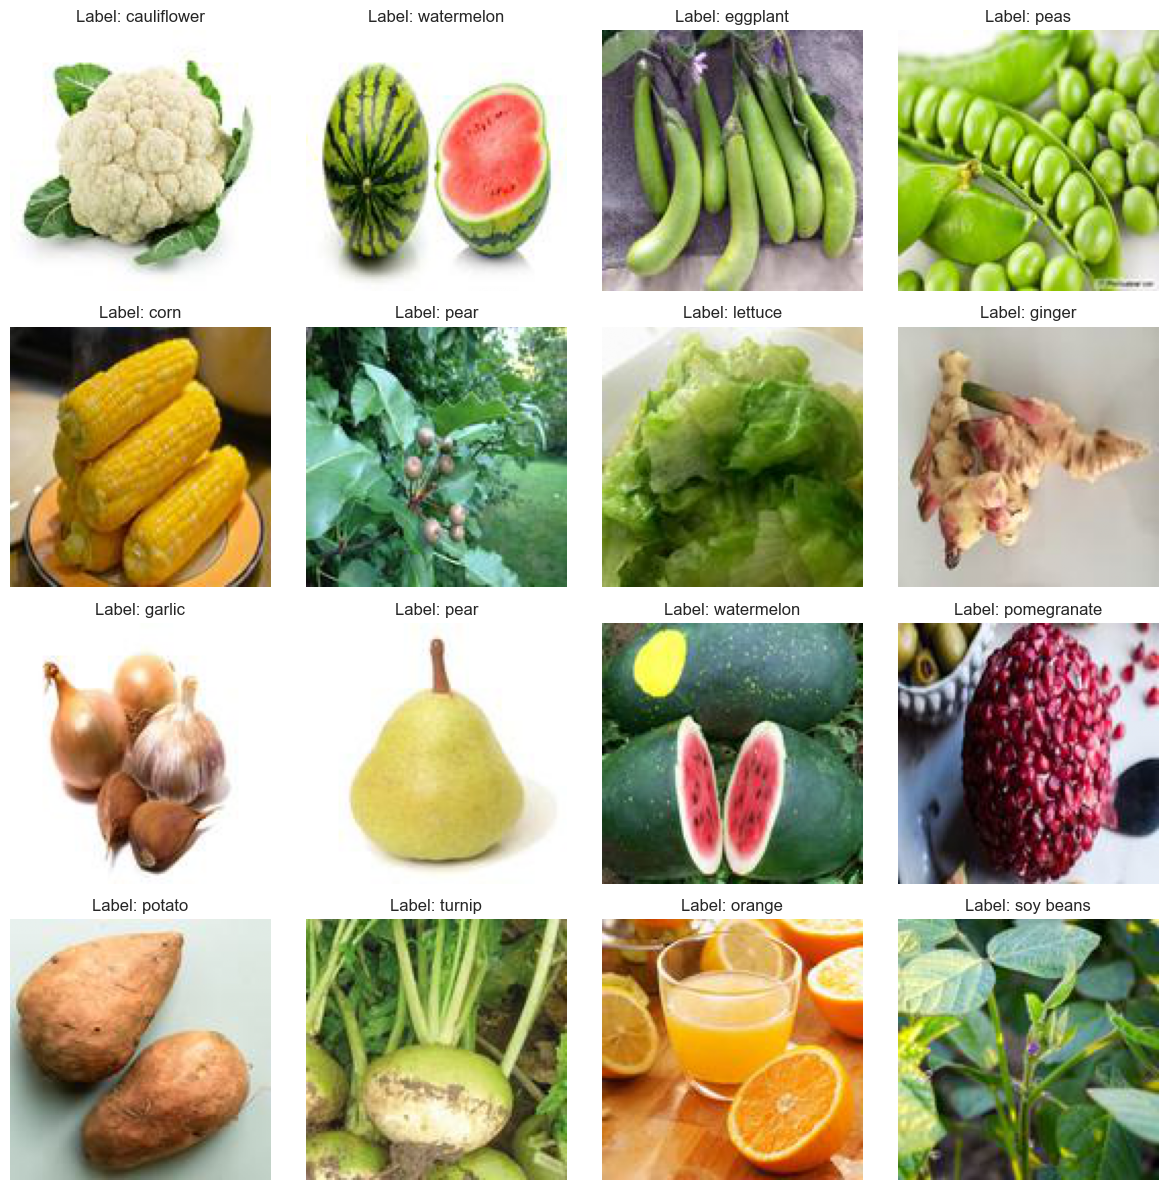

Fold 1
Training set class counts:
Class apple: 57
Class banana: 58
Class beetroot: 62
Class bell pepper: 70
Class cabbage: 68
Class carrot: 64
Class cauliflower: 60
Class chilli pepper: 70
Class corn: 65
Class cucumber: 70
Class eggplant: 63
Class garlic: 69
Class ginger: 53
Class grapes: 76
Class jalepeno: 68
Class kiwi: 67
Class lemon: 61
Class lettuce: 74
Class mango: 60
Class onion: 69
Class orange: 52
Class paprika: 62
Class pear: 68
Class peas: 73
Class pineapple: 75
Class pomegranate: 61
Class potato: 60
Class raddish: 63
Class soy beans: 74
Class spinach: 72
Class sweetpotato: 57
Class tomato: 73
Class turnip: 74
Class watermelon: 64
Validation set class counts:
Class apple: 15
Class banana: 14
Class beetroot: 16
Class bell pepper: 18
Class cabbage: 16
Class carrot: 16
Class cauliflower: 15
Class chilli pepper: 18
Class corn: 16
Class cucumber: 18
Class eggplant: 16
Class garlic: 18
Class ginger: 13
Class grapes: 19
Class jalepeno: 17
Class kiwi: 17
Class lemon: 15
Class lettuc

In [6]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

DIRS = [
    '/Users/alexchilton/Downloads/working2/train',
    '/Users/alexchilton/Downloads/working2/test'
]

exclude_classes = ['capsicum', 'sweetcorn']

# Update the load_images_from_folders function to return filenames
def load_images_from_folders(folders, image_size=(128, 128), exclude_classes=None, grayscale=False):
    if exclude_classes is None:
        exclude_classes = []
    images = []
    labels = []
    filenames = []
    for folder in folders:
        for class_name in os.listdir(folder):
            if class_name in exclude_classes:
                continue
            class_folder = os.path.join(folder, class_name)
            if os.path.isdir(class_folder):
                for filename in os.listdir(class_folder):
                    img_path = os.path.join(class_folder, filename)
                    img = Image.open(img_path)
                    if grayscale:
                        img = img.convert('L')  # Convert to grayscale
                        img = img.resize(image_size)  # Resize image to the specified size
                        img_array = np.array(img)
                        img_array = img_array[:, :, np.newaxis]  # Add channel dimension
                    else:
                        img = img.resize(image_size)  # Resize image to the specified size
                        img_array = np.array(img)
                        if img_array.shape == (image_size[0], image_size[1], 4):  # Check for RGBA images
                            img_array = img_array[:, :, :3]  # Discard the alpha channel
                        if img_array.shape != (image_size[0], image_size[1], 3):  # Ensure the image is RGB
                            print(f"Skipping image {img_path} due to incorrect shape: {img_array.shape}")
                            continue
                    img_array = img_array.flatten()  # Flatten the image
                    images.append(img_array)
                    labels.append(f"{class_name}")
                    filenames.append(img_path)  # Store the full path of the image

    return np.array(images), np.array(labels), filenames


from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline

# Load combined datasets
X, y, filenames = load_images_from_folders(DIRS, exclude_classes=exclude_classes, grayscale=False)
# Normalize the image data to [0, 1]
X = X / 255.0

# Ensure the labels are encoded as integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
# Select 16 random indices
random_indices = np.random.choice(len(X), 16, replace=False)

# Plot the images in a 4x4 grid
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
axes = axes.flatten()

for ax, idx in zip(axes, random_indices):
    img = X[idx].reshape(128, 128, 3)  # Reshape the flattened image
    ax.imshow(img)
    ax.set_title(f"Label: {label_encoder.inverse_transform([y_encoded[idx]])[0]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

# Normalize the image data to [0, 1]
X = X / 255.0

# Ensure the labels are encoded as integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Create a pipeline with preprocessing and the classifier
pipeline = make_pipeline( RandomForestClassifier(n_estimators=100, random_state=42))

# Use stratified cross-validation
stratified_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for fold, (train_index, val_index) in enumerate(stratified_kf.split(X, y_encoded)):
    y_train, y_val = y_encoded[train_index], y_encoded[val_index]

    train_class_counts = np.unique(y_train, return_counts=True)
    val_class_counts = np.unique(y_val, return_counts=True)

    print(f"Fold {fold + 1}")
    print("Training set class counts:")
    for cls, count in zip(*train_class_counts):
        print(f"Class {label_encoder.inverse_transform([cls])[0]}: {count}")

    print("Validation set class counts:")
    for cls, count in zip(*val_class_counts):
        print(f"Class {label_encoder.inverse_transform([cls])[0]}: {count}")
    print()
scores = cross_val_score(pipeline, X, y_encoded, cv=stratified_kf, scoring='accuracy')

print(f"Stratified Cross-Validation Accuracy: {scores.mean()} (+/- {scores.std() * 2})")







Stratified Cross-Validation Accuracy: 0.4218059154469268 (+/- 0.037611278311853354)
Cross-Validation Accuracy: 0.43494196701282833
Misclassified Samples:
Index: 0, Filename: /Users/alexchilton/Downloads/working2/train/apple/Image_28.jpg, Predicted: 21, Actual: 0
Index: 1, Filename: /Users/alexchilton/Downloads/working2/train/apple/Image_16.jpg, Predicted: 19, Actual: 0
Index: 2, Filename: /Users/alexchilton/Downloads/working2/train/apple/Image_17.jpg, Predicted: 25, Actual: 0
Index: 3, Filename: /Users/alexchilton/Downloads/working2/train/apple/Image_38.jpg, Predicted: 21, Actual: 0
Index: 4, Filename: /Users/alexchilton/Downloads/working2/train/apple/Image_10.jpg, Predicted: 21, Actual: 0
Index: 5, Filename: /Users/alexchilton/Downloads/working2/train/apple/Image_39.jpg, Predicted: 21, Actual: 0
Index: 7, Filename: /Users/alexchilton/Downloads/working2/train/apple/Image_62.jpg, Predicted: 29, Actual: 0
Index: 8, Filename: /Users/alexchilton/Downloads/working2/train/apple/Image_63.jpg,

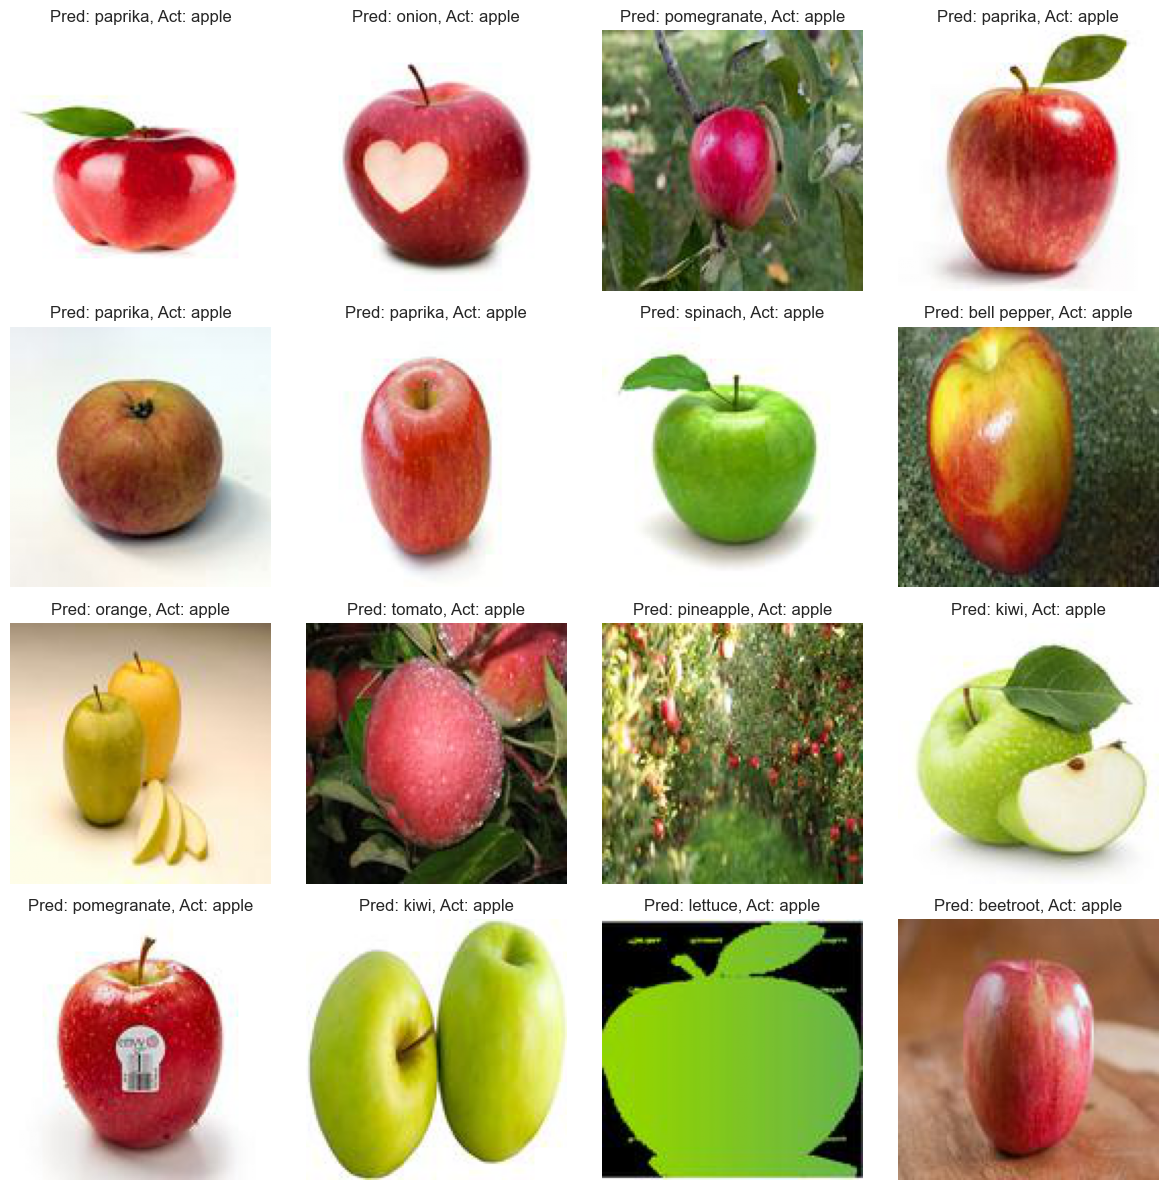

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Load combined datasets
X, y ,filenames = load_images_from_folders(DIRS, exclude_classes=exclude_classes, grayscale=False)

# Normalize the image data to [0, 1]
X = X / 255.0

# Ensure the labels are encoded as integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Create a pipeline with the classifier
pipeline = make_pipeline(RandomForestClassifier(n_estimators=100, random_state=42))

# Use stratified cross-validation
stratified_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X, y_encoded, cv=stratified_kf, scoring='accuracy')

print(f"Stratified Cross-Validation Accuracy: {scores.mean()} (+/- {scores.std() * 2})")

# Perform cross-validation and get predictions
y_pred = cross_val_predict(pipeline, X, y_encoded, cv=5)

# Calculate accuracy
accuracy = accuracy_score(y_encoded, y_pred)
print(f"Cross-Validation Accuracy: {accuracy}")

# Find misclassified samples
misclassified_indices = np.where(y_encoded != y_pred)[0]

# Print some misclassified samples
print("Misclassified Samples:")
for index in misclassified_indices[:10]:  # Print first 10 misclassified samples
    print(f"Index: {index}, Filename: {filenames[index]}, Predicted: {y_pred[index]}, Actual: {y_encoded[index]}")

# Plot some misclassified samples
num_samples = min(16, len(misclassified_indices))  # Plot up to 16 samples
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
axes = axes.flatten()

for ax, index in zip(axes, misclassified_indices[:num_samples]):
    img = X[index].reshape(128, 128, 3)  # Reshape the flattened image
    ax.imshow(img)
    ax.set_title(f"Pred: {label_encoder.inverse_transform([y_pred[index]])[0]}, Act: {label_encoder.inverse_transform([y_encoded[index]])[0]}")
    ax.axis('off')

plt.tight_layout()
plt.show()